# 1. Import Dependencies

In [153]:
!pip install gymnasium==0.28.1
!pip install 'shimmy>=0.2.1'
!pip install stable-baselines3

  Using cached gymnasium-0.28.1-py3-none-any.whl.metadata (9.2 kB)
  Using cached jax_jumpy-1.0.0-py3-none-any.whl.metadata (15 kB)
Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)
Using cached jax_jumpy-1.0.0-py3-none-any.whl (20 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1

[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
import gym
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from collections import deque
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 2. Building Replay Buffer & Environment

In [317]:
class ReplayBuffer:
    def __init__(self, buffer_size=2000):
        self.buffer = deque(maxlen=buffer_size)
        self.negative_experiences = set()
        self.positive_experiences = set()

    def add(self, experience):
        state, action, reward, next_state, done = experience
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        if reward <= 0:
            self.negative_experiences.add((state_tuple, action))
        elif reward == 4:
            self.positive_experiences.add((state_tuple, action))
        #self.buffer.append(experience)
        self.buffer.append((state_tuple, action, reward, next_state_tuple, done))

        # Print for debugging
        # print(f"Added experience: {experience}")

    def sample(self, batch_size):
        sample = random.sample(self.buffer, batch_size)

        # Print for debugging
        #print(f"Sampled batch: {sample}")

        return sample

    def __len__(self):
        return len(self.buffer)


In [318]:
def test_replay_buffer():
    buffer = ReplayBuffer(buffer_size=10)

    # Add some experiences
    for i in range(5):
        state = tuple(np.array([i, i+1, i+2, i+3]))
        action = i % 3
        reward = i
        next_state = tuple(np.array(state) + 1)
        done = i == 3
        buffer.add((state, action, reward, next_state, done))

    # Check buffer length
    assert len(buffer) == 5, "Buffer length should be 5"

    # Sample from buffer
    batch = buffer.sample(3)
    assert len(batch) == 3, "Sampled batch size should be 3"

    # Check content of buffer
    for experience in batch:
        state, action, reward, next_state, done = experience
        assert isinstance(state, tuple), "State should be a tuple"
        assert isinstance(next_state, tuple), "Next state should be a tuple"
        assert isinstance(action, int), "Action should be an int"
        assert isinstance(reward, int), "Reward should be an int"
        assert isinstance(done, bool), "Done should be a bool"

    print("All tests passed!")

# Run the test
test_replay_buffer()


All tests passed!


In [854]:
class PouroverEnv(Env):
    def __init__(self):
        self.action_space = Discrete(3)

        # Combine all observation spaces into a single Box space
        # 1:extra fine, 2:fine, 3:fine-medium, 4:medium, 5:medium-coarse, 6:coarse, 7:extra coarse
        low = np.array([1, 10, 120, 84], dtype=np.float32)
        high = np.array([7, 20, 300, 94], dtype=np.float32)                   # 5 minutes * 60 seconds = 300 seconds
        self.observation_space = Box(low, high, dtype=np.float32)

        self.reset()

    def step(self, action):

        self.state[0] += action - 1
        self.state[1] += action - 1
        self.state[2] += (action - 1) * 5 #5 seconds for each action
        self.state[3] += action - 1


        # Apply absolute value
        self.state = np.abs(self.state)

        # Clip the state values to their respective bounds
        self.state[0] = np.clip(self.state[0], 3, 5)
        #self.state[1] = np.clip(self.state[1], 12, 18)
        self.state[2] = int(np.round(np.clip(self.state[2], 120, 240)/5) * 5)
        #self.state[3] = np.clip(self.state[3], 86, 92)

        self.gsize_length -= 1
        self.bratio_length -= 1
        self.btime_length -= 1
        self.temperature_length -= 1

        reward = 0
        gsize_state, bratio_state, btime_state, temperature_state = self.state
        # levelroast_length, gsize_length, bratio_length, btime_length, temperature_length = self.length


        if gsize_state == 3:
          reward +=1
          if 12 <= bratio_state <= 14:
              reward += 1
          if 120 <= btime_state <= 180:
              reward += 1
          if 86 <= temperature_state <= 88:
              reward += 1
        elif gsize_state == 4:
          reward += 1
          if 14 <= bratio_state <= 16:
              reward += 1
          if 150 <= btime_state <= 180:
              reward += 1
          if 88 <= temperature_state <= 90:
            reward += 1
        elif gsize_state == 5:
          reward += 1
          if 16 <= bratio_state <= 18:
              reward += 1
          if 210 <= btime_state <= 240:
              reward += 1
          if 90 <= temperature_state <= 92:
            reward += 1

        #done = np.all(self.state == np.array([1, 2, 12, 1, 80], dtype=np.float32))
        done = self.gsize_length <= 0 and self.bratio_length <= 0 and self.btime_length <= 0 and self.temperature_length <= 0

        info = {}
        state = (self.state[0], self.state[1], self.state[2], self.state[3])
        return self.state, reward, done, info

    def get_evaluation_action(self, state):
      #0: turun, 1: tetap, 2: naik
      gsize_state, bratio_state, btime_state, temperature_state = state

      if 3 <= gsize_state <= 5:
        if gsize_state == 3:
          if 12 <= bratio_state <= 14 and 120 <= btime_state <= 180 and 86 <= temperature_state <= 88:
            return 1
          if bratio_state < 12:
            return 2
          if bratio_state > 14:
            return 0
          if btime_state < 120:
            return 2
          if btime_state > 180:
            return 0
          if temperature_state < 86:
            return 2
          if temperature_state > 88:
            return 0
        elif gsize_state == 4:
          if 14 <= bratio_state <= 16 and 150 <= btime_state <= 180 and 88 <= temperature_state <= 90:
            return 1
          if bratio_state < 14:
            return 2
          if bratio_state > 16:
            return 0
          if btime_state < 150:
            return 2
          if btime_state > 180:
            return 0
          if temperature_state < 88:
            return 2
          if temperature_state > 90:
            return 0
        elif gsize_state == 5:
          if 16 <= bratio_state <= 18 and 210 <= btime_state <= 240 and 90 <= temperature_state <= 92:
            return 1
          if bratio_state < 16:
            return 2
          if bratio_state > 18:
            return 0
          if btime_state < 210:
            return 2
          if btime_state > 240:
            return 0
          if temperature_state < 90:
            return 2
          if temperature_state > 92:
            return 0
      elif gsize_state > 5:
        return 0
      elif gsize_state < 3:
        return 2

      return 1  # Default action

    def reset(self):
        #self.gsize_state = 1 + random.randint(0, 6)
        self.gsize_state = 4 + random.randint(-1,1)
        #self.bratio_state = 10 + random.randint(0, 10)   # 14 to 20
        self.bratio_state = 15 + random.randint(-1,1)
        # brew time based on levelroast and grindsize
        #self.btime_state = 120 + random.randint(0, 36) * 5
        self.btime_state = 120 + random.randint(-5, 5)
        # temperature based on levelroast and grindsize
        #self.temperature_state = 84 + random.randint(0, 10)  # Default range for levelroast 2
        self.temperature_state = 89 + random.randint(-1,1)

        self.state = np.array([
            self.gsize_state,
            self.bratio_state,
            self.btime_state,
            self.temperature_state
        ]).astype(float)

        self.gsize_length = self.bratio_length = self.btime_length = self.temperature_length = 60
        return self.state


    def render(self):
        pass



In [855]:
# Instantiate the environment
env = PouroverEnv()
buffer = ReplayBuffer(buffer_size=2000)

In [856]:
env.observation_space.sample()

array([  1.6069459,  18.634115 , 156.41008  ,  84.259125 ], dtype=float32)

In [857]:
env.reset()

array([  4.,  14., 120.,  88.])

In [758]:
from stable_baselines3.common.env_checker import check_env

# 5. Train Model

In [357]:
log_path = os.path.join('Training', 'Logs')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [1024]:
#Training Model Prediction
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=200000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | 125      |
| time/              |          |
|    fps             | 4360     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60          |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 2894        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011200322 |
|    clip_fraction        | 0.0743      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00121     |
|    learning_rate        | 0.

In [1025]:
# Put experience into replay buffer
for _ in range(100):
    state = env.reset()
    state = tuple(state)
    done = False
    while not done:
        #action = env.action_space.sample()
        if np.random.rand() < 0.5:
            action = env.action_space.sample()
        else:
            action, _ = model.predict(state)
            action = int(action)
        next_state, reward, done, info = env.step(action)
        next_state = tuple(next_state)
        if reward == 4:
            buffer.add((state, action, reward, next_state, done))
            state = next_state

In [1032]:
# 3 action (Add ReplayBuffer to Action, takeout exploitation)

# Iteration w/ combine 3 actions in every episode
# Instantiate the environment
#env = PouroverEnv()
#buffer = ReplayBuffer(buffer_size=2000)

# Training Loop
episodes = 60
y_true_rl = []
y_pred_rl = []
rl_scores = []
rl_rewards = []
total_timesteps_rl = []
training_results_rl = []
count_rewards_rl = {}
count_rewards_action_sources = {}
total_actions = 0

epsilon = 0.5  # Exploration rate
epsilon_decay = 0.99  # Decay rate for exploration
min_epsilon = 0.01  # Minimum exploration rate

count_action_sources = {"Exploitation": 0, "Exploration": 0, "Model Prediction": 0}

for episode in range(1, episodes + 1):
    state = env.reset()
    state = tuple(state)  # Convert state to a hashable type
    done = False
    score = 0

    best_episode = None
    best_reward = -float('inf')
    best_score = 0
    best_action = None
    evaluation_best_action = None

    iteration = 0
    while not done:
        iteration += 1
        env.render()

        exploration_action = None
        predicted_action = None
        replay_action = None
        action_source = None


        # Check for exploration
        if action_source is None and np.random.rand() < epsilon:
            exploration_action = env.action_space.sample()
            action_source = "Exploration"

        # Check for replay buffer
        replay_experience = buffer.sample(1)
        if replay_experience:
            replay_state, replay_action, _, _, _ = replay_experience[0]
            if replay_state == state:
                action = replay_action
                action_source = "Exploitation"

        # Check for model prediction
        if action_source is None:
            predicted_action, _ = model.predict(state)
            predicted_action = int(predicted_action)
            action_source = "Model Prediction"


        # Choose the action based on source
        if exploration_action is not None:
            action = exploration_action
        elif action_source == "Exploitation":
            action = replay_action
        else:
            action = predicted_action


        # Increment the count for the action source
        if action_source in count_action_sources:
            count_action_sources[action_source] += 1
        else:
            print(f"Unknown action source: {action_source}")
        total_actions += 1

        # Execute the action in the environment
        evaluation_action = env.get_evaluation_action(state)

        while (state, action) in buffer.negative_experiences:
            action = env.action_space.sample()

        next_state, reward, done, info = env.step(action)
        next_state = tuple(next_state)  # Convert next_state to a hashable type
        score += reward

        buffer.add((state, action, reward, next_state, done))

        if reward == 4:
            for _ in range(100):
                buffer.add((state, action, reward, next_state, done))


        # Print state awal, action, next state, and reward
        #if action != evaluation_action  and reward ==5:
        print(f'Episode {episode}, Iteration {iteration}, State: {state}, Agent Action: {action}, Evaluation Action {evaluation_action}, Next State: {next_state}, Reward: {reward}, , Cumulative Score: {score}, Action Source: {action_source}')

        state = next_state

        # Track the best reward in every episode
        if reward > best_reward:
            best_reward = reward
            best_episode = (state, action, reward, next_state, done, score, action_source)
            best_action = action
            evaluation_best_action = evaluation_action


        # Print iteration details
        # print(f'Episode: {episode}, Iteration: {iteration}, State: {state}, Action: {action}, evaluation action: {evaluation_action}, Reward: {reward}, Cumulative Score: {score}, Action Source: {action_source}')

    # Print the best episode found in this iteration
    if best_episode:
        best_state, best_action, best_reward, best_next_state, best_done, best_score, best_action_source = best_episode
        gsize_state, bratio_state, btime_state, temperature_state = best_state

        rl_scores.append(score)
        rl_rewards.append(best_reward)
        total_timesteps_rl.append(iteration)

        # Convert btime_state from seconds to minutes and seconds
        minutes = int(btime_state // 60)
        seconds = int(btime_state % 60)

        # Store training results in the list
        training_results_rl.append({
            'Episode': episode,
            'Score': score,
            'Best Reward': best_reward,
            'Gsize State': gsize_state,
            'Bratio State': bratio_state,
            'Btime State (sec)': btime_state,
            'Btime State (min:sec)': f'{minutes} minutes {seconds} seconds',
            'Temperature State': temperature_state,
            'Best Action Source': best_action_source
        })
        
        #if best_reward == 5:
        #if best_action != evaluation_best_action and best_reward ==5:
        print(f'Episode: {episode} Best Action: {best_action} Best evaluation action: {evaluation_best_action}')
        print(f'Episode: {episode} Score: {score} Best Reward: {best_reward} Gsize State: {gsize_state} Bratio State: 1:{bratio_state} Btime State: {btime_state} convert: {minutes} minutes {seconds} seconds Temperature State: {temperature_state} Best Action Source: {best_action_source}')

    # Append the best action and its corresponding evaluation action
    if best_action is not None and evaluation_best_action is not None:
        if best_action != evaluation_best_action and best_reward ==4:
            y_true_rl.append(best_action)
            y_pred_rl.append(best_action)
        else:
            y_true_rl.append(evaluation_best_action)
            y_pred_rl.append(best_action)

    # Count total for every reward
    if best_reward in count_rewards_rl:
        count_rewards_rl[best_reward] += 1
    else:
        count_rewards_rl[best_reward] = 1

    # Count total reward w/ action source
    if best_reward not in count_rewards_action_sources:
        count_rewards_action_sources[best_reward] = {"Exploration": 0, "Exploitation": 0, "Model Prediction": 0}
    count_rewards_action_sources[best_reward][action_source] += 1

    # Decay epsilon
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay

env.close()


Episode 1, Iteration 1, State: (5.0, 16.0, 118.0, 89.0), Agent Action: 1, Evaluation Action 2, Next State: (5.0, 16.0, 120.0, 89.0), Reward: 2, , Cumulative Score: 2, Action Source: Model Prediction
Episode 1, Iteration 2, State: (5.0, 16.0, 120.0, 89.0), Agent Action: 2, Evaluation Action 2, Next State: (5.0, 17.0, 125.0, 90.0), Reward: 3, , Cumulative Score: 5, Action Source: Exploration
Episode 1, Iteration 3, State: (5.0, 17.0, 125.0, 90.0), Agent Action: 0, Evaluation Action 2, Next State: (4.0, 16.0, 120.0, 89.0), Reward: 3, , Cumulative Score: 8, Action Source: Exploration
Episode 1, Iteration 4, State: (4.0, 16.0, 120.0, 89.0), Agent Action: 2, Evaluation Action 2, Next State: (5.0, 17.0, 125.0, 90.0), Reward: 3, , Cumulative Score: 11, Action Source: Exploration
Episode 1, Iteration 5, State: (5.0, 17.0, 125.0, 90.0), Agent Action: 1, Evaluation Action 2, Next State: (5.0, 17.0, 125.0, 90.0), Reward: 3, , Cumulative Score: 14, Action Source: Model Prediction
Episode 1, Iterati

In [1042]:
buffer_size = len(buffer)
print(f"Jumlah data dalam replay buffer: {buffer_size}")

Jumlah data dalam replay buffer: 2000


In [1043]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(training_results_rl)

# Simpan DataFrame ke file Excel
df.to_excel('training_results_rl.xlsx', index=False)

print(f"Data hasil training berhasil diekspor ke 'training_results_rl.xlsx'.")

Data hasil training berhasil diekspor ke 'training_results_rl.xlsx'.


In [1044]:
# Pull all experiences to replay buffer
all_experiences = []
for _ in range(len(buffer)): 
    experience = buffer.sample(1)
    state, action, reward, next_state, done = experience[0]
    all_experiences.append((state, action, reward, next_state, done))

# Change to DataFrame
df = pd.DataFrame(all_experiences, columns=['State', 'Action', 'Reward', 'Next_State', 'Done'])

# Save to Excel
df.to_excel('all_data_replay_buffer.xlsx', index=False)

print(f"Success export to 'all_data_replay_buffer.xlsx'.")


Success export to 'all_data_replay_buffer.xlsx'.


In [1033]:
# Print the total counts of each reward
for reward, count in sorted(count_rewards_rl.items()):
    print(f'Reward {reward}: {count} times')

Reward 3: 6 times
Reward 4: 54 times


In [1040]:
# Print the total counts for every reward w/ action sources
for best_reward, count in sorted(count_rewards_rl.items()):
    print(f'\nTotal Reward {best_reward}: {count} times')
    for source, count in count_rewards_action_sources[best_reward].items():
        print(f'  {source}: {count} times')


Total Reward 3: 6 times
  Exploration: 4 times
  Exploitation: 0 times
  Model Prediction: 2 times

Total Reward 4: 54 times
  Exploration: 17 times
  Exploitation: 1 times
  Model Prediction: 36 times


In [1039]:
for source, count in count_action_sources.items():
    percentage = (count / total_actions) * 100
    print(f"{source}: {percentage:.2f}%")

Exploitation: 4.19%
Exploration: 36.33%
Model Prediction: 59.47%


In [1041]:
def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted') #macro for individual
    recall = recall_score(y_true, y_pred, average='weighted') #  weighted for distribution value
    f1 = f1_score(y_true, y_pred, average='weighted')

    accuracy *= 100
    precision *= 100
    recall *= 100
    f1 *= 100

    # Extract TP, TN, FP, FN for each class if needed
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        return cm, accuracy, precision, recall, f1, tp, tn, fp, fn
    else:
        return cm, accuracy, precision, recall, f1

# Example usage:
cm, accuracy, precision, recall, f1, *confusion_values = evaluate_model(y_true_rl, y_pred_rl)
print(f'Confusion Matrix:\n{cm}')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

# If you need to print confusion values for 2-class case
if len(confusion_values) == 4:
    tp, tn, fp, fn = confusion_values
    print(f'True Positives: {tp}')
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')


Confusion Matrix:
[[54  0  1]
 [ 0  1  0]
 [ 1  1  2]]
Accuracy: 95.00%
Precision: 95.28%
Recall: 95.00%
F1 Score: 94.92%


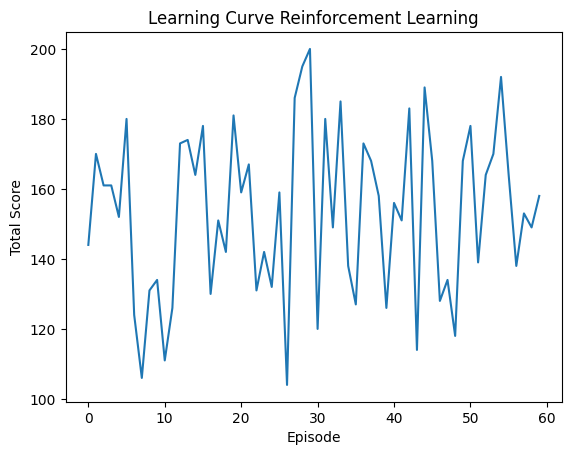

In [1035]:
# Learning Curve RL
def plot_learning_curve(env, model):

    plt.plot(rl_scores)
    plt.xlabel('Episode')
    plt.ylabel('Total Score')
    plt.title('Learning Curve Reinforcement Learning')
    plt.show()

plot_learning_curve(env, model)


In [925]:
# Generate data for KNN
states = []
actions = []
for _ in range(3600):  # generate 3600 samples
    state = env.reset()
    state = tuple(state)

    action = env.action_space.sample()
    states.append(state)
    actions.append(action)

In [1045]:
# For save generate data KNN
# Convert data to DataFrame
data = pd.DataFrame(states, columns=['Gsize', 'Bratio', 'Btime', 'Temperature'])
data['Action'] = actions

# Save to Excel
data.to_excel('generated_data_knn.xlsx', index=False)

print("Successfully generate! saved to 'generated_data_knn.xlsx'")

Successfully generate! saved to 'generated_data_knn.xlsx'


In [991]:
# Training KNN

# Split data train & test
X_train, X_test, y_train, y_test = train_test_split(states, actions, test_size=0.2, random_state=42)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Testing Loop for KNN
episodes = 60
knn_scores = []
knn_rewards = []
y_true_knn = []
y_pred_knn = []
training_results_knn = []
total_timesteps_knn = []
count_rewards_knn = {}

for episode in range(1, episodes + 1):
    state = env.reset()
    # Add small integer noise to all state elements except btime (index 3)
    state = tuple(state)
    done = False
    score = 0
    iterations = 0

    best_episode = None
    best_reward = -float('inf')
    best_score = 0
    best_action = None
    evaluation_best_action = None

    while not done:
        iterations += 1
        env.render()
        state = list(state)

        # gsize_state
        state[0] = 1 + random.randint(0, 6)
        #state[0] = 4 + random.randint(-1, 1)
        # bratio_state
        #state[1] = 10 + random.randint(0, 10)
        #state[1] = 15 + random.randint(-1, 1)
        # btime_state
        #state[2] = 100 + random.randint(0, 40) * 5
        #state[2] = 120 + random.randint(-5, 5)
        # temperature_state
        #state[3] = 89 + random.randint(-1, 1)

        action = knn.predict([state])[0]
        evaluation_action = env.get_evaluation_action(state)

        next_state, reward, done, info = env.step(action)
        next_state = tuple(next_state)
        score += reward

        #if action != evaluation_action:
        print(f'Episode {episode}, Iteration {iteration}, State: {state}, Agent Action: {action}, Evaluation Action {evaluation_action}, Next State: {next_state}, Reward: {reward}, , Cumulative Score: {score}')

        state = next_state

        gsize_state, bratio_state, btime_state, temperature_state = next_state
        # Track the best reward in every episode
        if reward > best_reward:
            best_reward = reward
            best_episode = (state, action, reward, next_state, done, score)
            best_action = action
            evaluation_best_action = evaluation_action

    if best_episode:
        best_state, best_action, best_reward, best_next_state, best_done, best_score = best_episode
        gsize_state, bratio_state, btime_state, temperature_state = best_state
                    
        knn_scores.append(score)
        knn_rewards.append(best_reward)
        total_timesteps_knn.append(iterations)
        

        minutes = int(btime_state // 60)
        seconds = int(btime_state % 60)

        # Store training results in the list
        training_results_knn.append({
            'Episode': episode,
            'Score': score,
            'Reward': best_reward,
            'Gsize State': gsize_state,
            'Bratio State': bratio_state,
            'Btime State (sec)': btime_state,
            'Btime State (min:sec)': f'{minutes} minutes {seconds} seconds',
            'Temperature State': temperature_state
        })

        #if action != evaluation_best_action:
        print(f'Episode: {episode} Best Action: {best_action} Best evaluation action: {evaluation_best_action}')
        print(f'Episode: {episode} Score: {score} Best Reward: {best_reward} Gsize State: {gsize_state} Bratio State: 1:{bratio_state} Btime State: {btime_state} convert: {minutes} minutes {seconds} seconds Temperature State: {temperature_state}')

    # Append the best action and its corresponding evaluation action
    if best_action is not None and evaluation_best_action is not None:
        if best_action != evaluation_best_action and best_reward ==4:
            y_true_knn.append(best_action)
            y_pred_knn.append(best_action)
        else:
            y_true_knn.append(evaluation_best_action)
            y_pred_knn.append(best_action)

    # Count total for every reward
    if best_reward in count_rewards_knn:
        count_rewards_knn[best_reward] += 1
    else:
        count_rewards_knn[best_reward] = 1
        
env.close()

Episode 1, Iteration 60, State: [2, 15.0, 124.0, 90.0], Agent Action: 2, Evaluation Action 2, Next State: (5.0, 16.0, 130.0, 91.0), Reward: 3, , Cumulative Score: 3
Episode 1, Iteration 60, State: [1, 16.0, 130.0, 91.0], Agent Action: 0, Evaluation Action 2, Next State: (4.0, 15.0, 125.0, 90.0), Reward: 3, , Cumulative Score: 6
Episode 1, Iteration 60, State: [1, 15.0, 125.0, 90.0], Agent Action: 1, Evaluation Action 2, Next State: (4.0, 15.0, 125.0, 90.0), Reward: 3, , Cumulative Score: 9
Episode 1, Iteration 60, State: [4, 15.0, 125.0, 90.0], Agent Action: 0, Evaluation Action 2, Next State: (3.0, 14.0, 120.0, 89.0), Reward: 3, , Cumulative Score: 12
Episode 1, Iteration 60, State: [6, 14.0, 120.0, 89.0], Agent Action: 0, Evaluation Action 0, Next State: (3.0, 13.0, 120.0, 88.0), Reward: 4, , Cumulative Score: 16
Episode 1, Iteration 60, State: [5, 13.0, 120.0, 88.0], Agent Action: 2, Evaluation Action 2, Next State: (4.0, 14.0, 125.0, 89.0), Reward: 3, , Cumulative Score: 19
Episode

In [1046]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(training_results_knn)

# Simpan DataFrame ke file Excel
df.to_excel('training_results_knn.xlsx', index=False)

print(f"Data hasil training berhasil diekspor ke 'training_results_knn.xlsx'.")

Data hasil training berhasil diekspor ke 'training_results_knn.xlsx'.


In [992]:
# Print the total counts of each reward
for best_reward, count in sorted(count_rewards_knn.items()):
    print(f'Reward {best_reward}: {count} times')

Reward 3: 13 times
Reward 4: 47 times


In [993]:
def evaluate_knn(y_true_knn, y_pred_knn):
    # Calculate metrics
    conf_matrix = confusion_matrix(y_true_knn, y_pred_knn)
    accuracy = accuracy_score(y_true_knn, y_pred_knn)
    precision = precision_score(y_true_knn, y_pred_knn, average='weighted')
    recall = recall_score(y_true_knn, y_pred_knn, average='weighted')
    f1 = f1_score(y_true_knn, y_pred_knn, average='weighted')

    # Convert to percentage
    accuracy *= 100
    precision *= 100
    recall *= 100
    f1 *= 100

    return conf_matrix, accuracy, precision, recall, f1

conf_matrix, knn_accuracy, knn_precision, knn_recall, knn_f1 = evaluate_knn(y_true_knn, y_pred_knn)
#print(y_pred_knn)
#print(y_true_knn)
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {knn_accuracy:.2f}%')
print(f'Precision: {knn_precision:.2f}%')
print(f'Recall: {knn_recall:.2f}%')
print(f'F1 Score: {knn_f1:.2f}%')

Confusion Matrix:
[[49  2  0]
 [ 0  0  0]
 [ 3  2  4]]
Accuracy: 88.33%
Precision: 95.10%
Recall: 88.33%
F1 Score: 90.10%


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


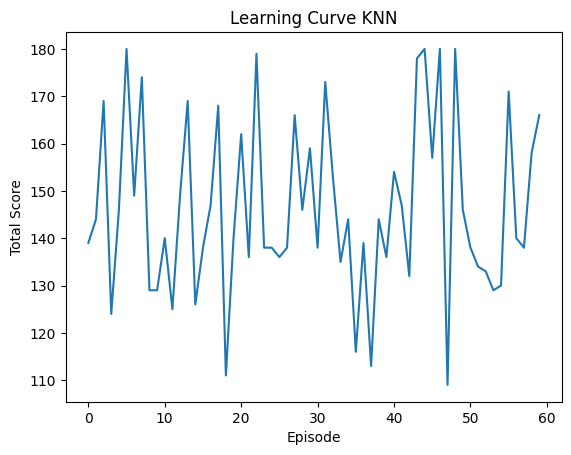

In [1047]:
# Learning Curve KNN
def plot_learning_curve(env, model):

    plt.plot(knn_scores)
    plt.xlabel('Episode')
    plt.ylabel('Total Score')
    plt.title('Learning Curve KNN')
    plt.show()

plot_learning_curve(env, model)


In [206]:
env.close()

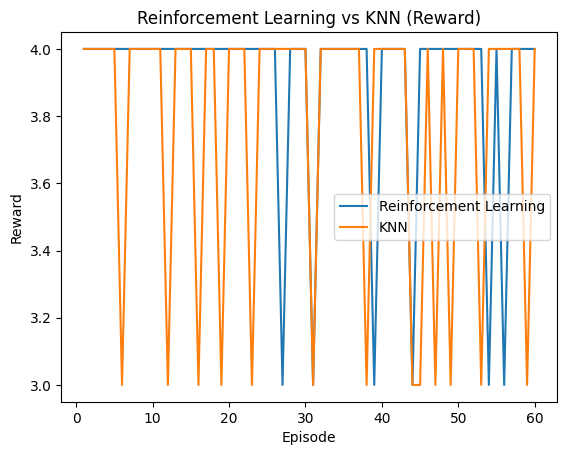

In [1048]:
# Compare Reward RL & KNN
plt.plot(range(1, episodes + 1), rl_rewards, label='Reinforcement Learning')
plt.plot(range(1, episodes + 1), knn_rewards, label='KNN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reinforcement Learning vs KNN (Reward)')
plt.legend()
plt.show()


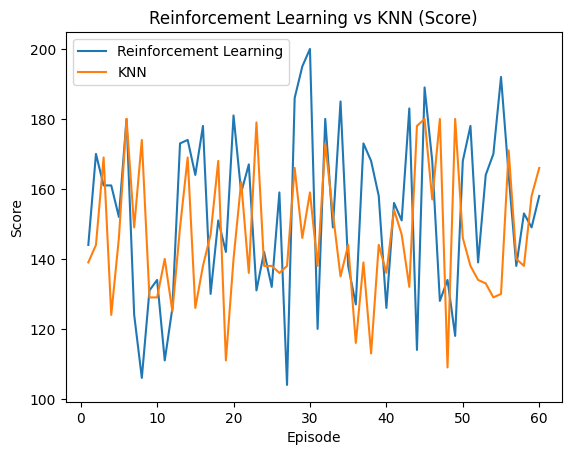

In [1049]:
# Compare Score RL & KNN
plt.plot(range(1, episodes + 1), rl_scores, label='Reinforcement Learning')
plt.plot(range(1, episodes + 1), knn_scores, label='KNN')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Reinforcement Learning vs KNN (Score)')
plt.legend()
plt.show()


In [1038]:
# Average Rewards
avg_reward_rl = np.mean(rl_rewards)
print(f'Average Reward RL: {avg_reward_rl:.2f}')
avg_reward_knn = np.mean(knn_rewards)
print(f'Average Reward KNN: {avg_reward_knn:.2f}\n')

# Average Scores
avg_score_rl = np.mean(rl_scores)
print(f'Average Score RL: {avg_score_rl:.2f}')
avg_score_knn = np.mean(knn_scores)
print(f'Average Score KNN: {avg_score_knn:.2f}')

Average Reward RL: 3.90
Average Reward KNN: 3.78

Average Score RL: 153.43
Average Score KNN: 146.42


# 6. Save Model

In [211]:
model.save('PPO')
evaluate_policy(model, env, n_eval_episodes=60, render=True)

/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


(193.53333333333333, 98.98307374944916)